## 1. LIBRARY IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported")
print(f"Using statsmodels for VAR model")

✓ Libraries imported
Using statsmodels for VAR model


## 2. DATA LOADING

In [2]:
# ===== CONFIGURATION =====
# Load ALL appliances for multi-output prediction

# Base data path
DATA_BASE_PATH = os.path.join("..", "data", "processed", "15min", "model_ready")

# List of available appliances
available_appliances = [d for d in os.listdir(DATA_BASE_PATH) 
                        if os.path.isdir(os.path.join(DATA_BASE_PATH, d))]
print(f"Available appliances: {available_appliances}")
print(f"Total appliances: {len(available_appliances)}\n")

# Load input data (X) from first appliance (all appliances share same input)
first_appliance = available_appliances[0]
APPLIANCE_PATH = os.path.join(DATA_BASE_PATH, first_appliance)

X_train = np.load(os.path.join(APPLIANCE_PATH, "X_train.npy"))
X_val = np.load(os.path.join(APPLIANCE_PATH, "X_val.npy"))
X_test = np.load(os.path.join(APPLIANCE_PATH, "X_test.npy"))

print(f"Input data loaded from: {first_appliance}")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")

# Load target data (y) for ALL appliances
y_train_dict = {}
y_val_dict = {}
y_test_dict = {}

print(f"\n📦 Loading targets for all appliances...")
for appliance in available_appliances:
    appliance_path = os.path.join(DATA_BASE_PATH, appliance)
    
    y_train_dict[appliance] = np.load(os.path.join(appliance_path, "y_train.npy"))
    y_val_dict[appliance] = np.load(os.path.join(appliance_path, "y_val.npy"))
    y_test_dict[appliance] = np.load(os.path.join(appliance_path, "y_test.npy"))
    
    print(f"  ✓ {appliance}: {y_train_dict[appliance].shape}")

# Stack all appliances into a single multi-output target
# Shape: (samples, seq_len, num_appliances)
y_train = np.stack([y_train_dict[app] for app in available_appliances], axis=-1).squeeze(2)
y_val = np.stack([y_val_dict[app] for app in available_appliances], axis=-1).squeeze(2)
y_test = np.stack([y_test_dict[app] for app in available_appliances], axis=-1).squeeze(2)

print(f"\n✓ Multi-output targets created:")
print(f"  y_train: {y_train.shape} (samples, seq_len, appliances)")
print(f"  y_val:   {y_val.shape}")
print(f"  y_test:  {y_test.shape}")

# ===== DATA CLEANING: THRESHOLD FOR NEAR-ZERO VALUES =====
ZERO_THRESHOLD = 0.001  # Values below this threshold become 0

# Count values before cleaning
before_train = np.sum((y_train > 0) & (y_train < ZERO_THRESHOLD))
before_val = np.sum((y_val > 0) & (y_val < ZERO_THRESHOLD))
before_test = np.sum((y_test > 0) & (y_test < ZERO_THRESHOLD))

# Apply threshold to targets (y)
y_train = np.where(y_train < ZERO_THRESHOLD, 0.0, y_train)
y_val = np.where(y_val < ZERO_THRESHOLD, 0.0, y_val)
y_test = np.where(y_test < ZERO_THRESHOLD, 0.0, y_test)

print(f"\n🧹 Cleaning near-zero values (threshold={ZERO_THRESHOLD}):")
print(f"   Train: {before_train:,} values → 0")
print(f"   Val:   {before_val:,} values → 0")
print(f"   Test:  {before_test:,} values → 0")

# Load scaler if available
scaler_path = os.path.join(DATA_BASE_PATH, "scaler.pkl")
if os.path.exists(scaler_path):
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    print(f"✓ Scaler loaded from {scaler_path}")
else:
    scaler = None
    print("⚠️ Scaler not found, data might already be normalized")

print(f"\n✓ Multi-appliance dataset loaded:")
print(f"  X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape} | y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape} | y_test:  {y_test.shape}")

# Determine parameters from data
# X shape: (samples, seq_len, num_features)
# y shape: (samples, seq_len, num_appliances)
window_size = X_train.shape[1]  # 99 timesteps
num_input_features = X_train.shape[2]  # 7 features
num_appliances = y_train.shape[2]  # All appliances

print(f"\n✓ Window size: {window_size} timesteps")
print(f"✓ Input features: {num_input_features}")
print(f"✓ Target appliances: {num_appliances}")
print(f"✓ Appliances: {', '.join(available_appliances)}")

Available appliances: ['chargingstation_socket', 'dishwasher', 'dryer', 'garagecabinet', 'heatpump', 'heatpump_controller', 'oven', 'rainwaterpump', 'rangehood', 'smappeecharger', 'stove', 'washingmachine']
Total appliances: 12

Input data loaded from: chargingstation_socket
  X_train: (24097, 96, 7)
  X_val:   (5377, 96, 7)
  X_test:  (5281, 96, 7)

📦 Loading targets for all appliances...
  ✓ chargingstation_socket: (24097, 96, 1)
  ✓ dishwasher: (24097, 96, 1)
  ✓ dryer: (24097, 96, 1)
  ✓ garagecabinet: (24097, 96, 1)
  ✓ heatpump: (24097, 96, 1)
  ✓ heatpump_controller: (24097, 96, 1)
  ✓ oven: (24097, 96, 1)
  ✓ rainwaterpump: (24097, 96, 1)
  ✓ rangehood: (24097, 96, 1)
  ✓ smappeecharger: (24097, 96, 1)
  ✓ stove: (24097, 96, 1)
  ✓ washingmachine: (24097, 96, 1)

✓ Multi-output targets created:
  y_train: (24097, 96, 12) (samples, seq_len, appliances)
  y_val:   (5377, 96, 12)
  y_test:  (5281, 96, 12)

🧹 Cleaning near-zero values (threshold=0.001):
   Train: 6,145,611 values →

## 3. EXPLORATORY DATA ANALYSIS

In [3]:
# Analyze loaded data
print("=== DATASET STATISTICS ===")
print(f"\n📊 Input (X) - {num_input_features} features:")
print(f"  Train: min={X_train.min():.4f}, max={X_train.max():.4f}, mean={X_train.mean():.4f}")
print(f"  Val:   min={X_val.min():.4f}, max={X_val.max():.4f}, mean={X_val.mean():.4f}")
print(f"  Test:  min={X_test.min():.4f}, max={X_test.max():.4f}, mean={X_test.mean():.4f}")

print(f"\n📊 Target (y - ALL APPLIANCES):")
print(f"  Train: min={y_train.min():.4f}, max={y_train.max():.4f}, mean={y_train.mean():.4f}")
print(f"  Val:   min={y_val.min():.4f}, max={y_val.max():.4f}, mean={y_val.mean():.4f}")
print(f"  Test:  min={y_test.min():.4f}, max={y_test.max():.4f}, mean={y_test.mean():.4f}")

print(f"\n📊 Statistics per appliance (y_train):")
for i, appliance in enumerate(available_appliances):
    app_data = y_train[:, :, i]
    print(f"  {appliance}: min={app_data.min():.4f}, max={app_data.max():.4f}, mean={app_data.mean():.4f}")

print(f"\n📊 Dimensions:")
print(f"  Total sequences: {len(X_train) + len(X_val) + len(X_test)}")
print(f"  Train: {len(X_train)} ({len(X_train)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")
print(f"  Val:   {len(X_val)} ({len(X_val)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")
print(f"  Test:  {len(X_test)} ({len(X_test)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")

=== DATASET STATISTICS ===

📊 Input (X) - 7 features:
  Train: min=0.0000, max=1.0000, mean=0.4376
  Val:   min=0.0000, max=1.0000, mean=0.4454
  Test:  min=0.0000, max=1.0000, mean=0.4467

📊 Target (y - ALL APPLIANCES):
  Train: min=0.0000, max=1.0000, mean=0.0444
  Val:   min=0.0000, max=0.9945, mean=0.0538
  Test:  min=0.0000, max=1.2496, mean=0.0528

📊 Statistics per appliance (y_train):
  chargingstation_socket: min=0.0000, max=1.0000, mean=0.0235
  dishwasher: min=0.0000, max=1.0000, mean=0.0153
  dryer: min=0.0000, max=1.0000, mean=0.0008
  garagecabinet: min=0.0000, max=1.0000, mean=0.1338
  heatpump: min=0.0000, max=1.0000, mean=0.1147
  heatpump_controller: min=0.0000, max=1.0000, mean=0.1788
  oven: min=0.0000, max=1.0000, mean=0.0099
  rainwaterpump: min=0.0000, max=1.0000, mean=0.0004
  rangehood: min=0.0000, max=1.0000, mean=0.0101
  smappeecharger: min=0.0000, max=1.0000, mean=0.0217
  stove: min=0.0000, max=1.0000, mean=0.0039
  washingmachine: min=0.0000, max=1.0000, m

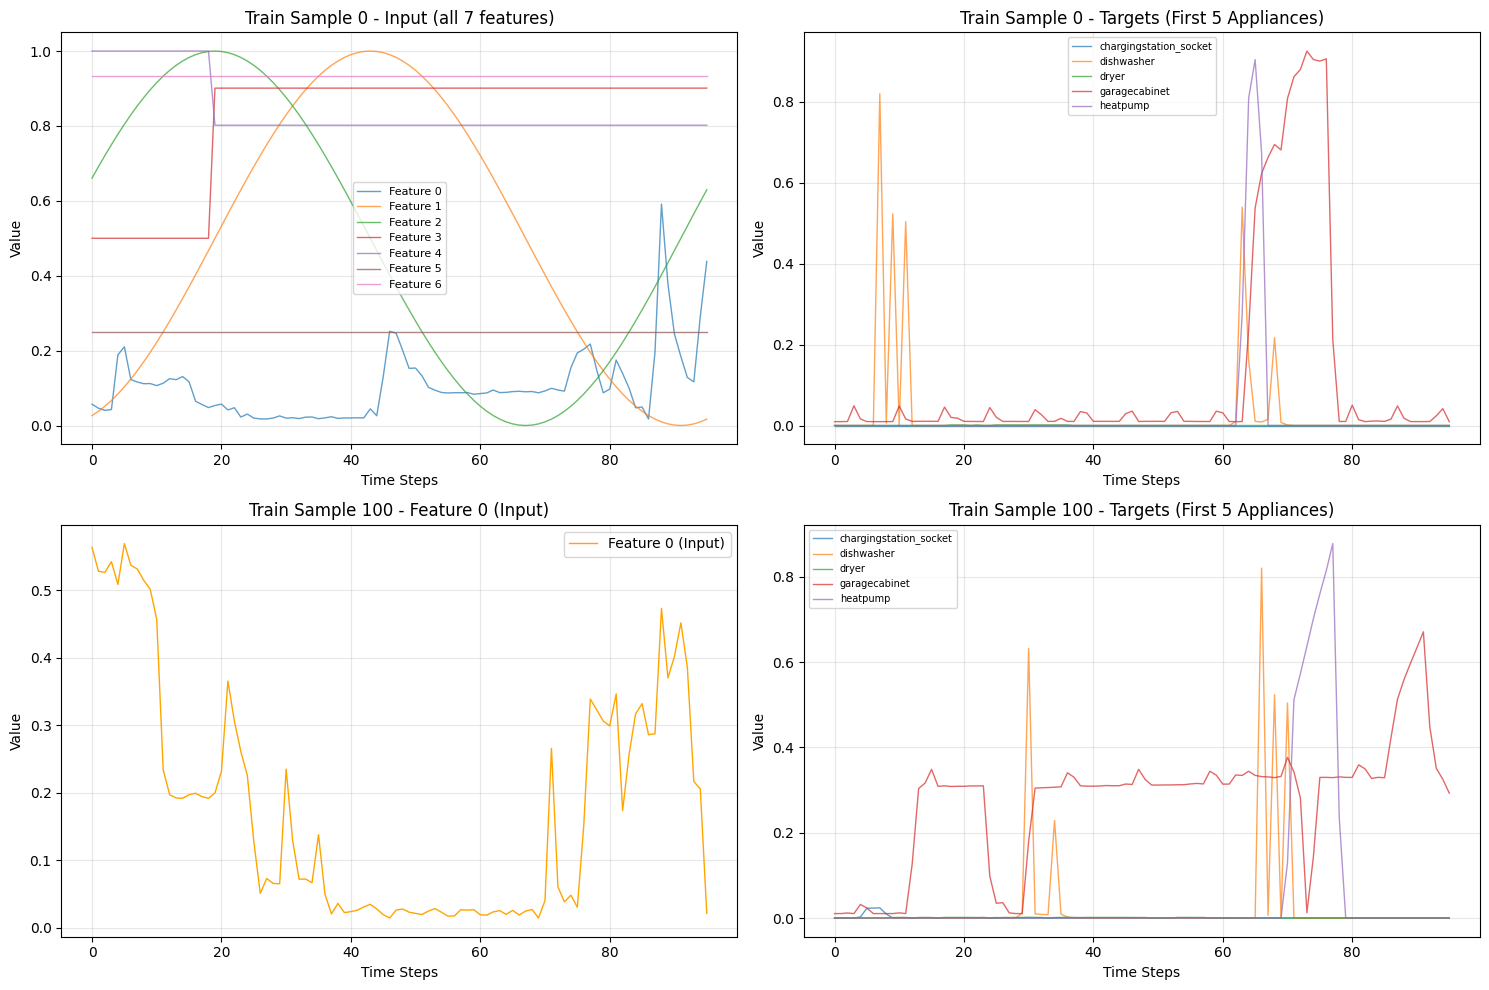

In [4]:
# Visualize some example sequences
sample_idx = 0

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot all input features for first sample
ax = axes[0, 0]
for i in range(num_input_features):
    ax.plot(X_train[sample_idx, :, i], linewidth=1, label=f'Feature {i}', alpha=0.7)
ax.set_title(f'Train Sample {sample_idx} - Input (all {num_input_features} features)')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Value')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

# Target for first sample - show first 5 appliances
ax = axes[0, 1]
for i, appliance in enumerate(available_appliances[:5]):
    ax.plot(y_train[sample_idx, :, i], linewidth=1, alpha=0.7, label=appliance)
ax.set_title(f'Train Sample {sample_idx} - Targets (First 5 Appliances)')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Value')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=7)

# Second sequence - only feature 0 (assuming it's the main aggregate)
sample_idx_2 = min(100, len(X_train)-1)
ax = axes[1, 0]
ax.plot(X_train[sample_idx_2, :, 0], linewidth=1, color='orange', label='Feature 0 (Input)')
ax.set_title(f'Train Sample {sample_idx_2} - Feature 0 (Input)')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Value')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1, 1]
for i, appliance in enumerate(available_appliances[:5]):
    ax.plot(y_train[sample_idx_2, :, i], linewidth=1, alpha=0.7, label=appliance)
ax.set_title(f'Train Sample {sample_idx_2} - Targets (First 5 Appliances)')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Value')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=7)

plt.tight_layout()
plt.show()

## 4. DATA PREPARATION FOR VAR

VAR requires time series data where we combine input features with target for multivariate forecasting.

In [5]:
# ===== PREPARE DATA FOR VAR =====
# VAR expects: each sample is a multivariate time series
# We'll combine input features + all targets into one multivariate series
# Then use VAR to forecast all target features

print("🔄 Preparing data for VAR model...")

# For VAR, we need to work with each sequence individually
# We'll train separate VAR models or use a pooled approach
# Here we use a simpler approach: average VAR model trained on concatenated data

def prepare_var_data(X, y):
    """
    Combine X and y into multivariate series
    X: (samples, timesteps, features)
    y: (samples, timesteps, num_appliances)
    Returns: (samples, timesteps, features + num_appliances)
    """
    combined = np.concatenate([X, y], axis=2)
    return combined

train_data_var = prepare_var_data(X_train, y_train)
val_data_var = prepare_var_data(X_val, y_val)
test_data_var = prepare_var_data(X_test, y_test)

# Create column names for DataFrame
feature_cols = [f'feat_{j}' for j in range(num_input_features)]
target_cols = [f'target_{app}' for app in available_appliances]
all_cols = feature_cols + target_cols

print(f"✓ VAR data prepared:")
print(f"  Train: {train_data_var.shape} (samples, timesteps, {num_input_features} features + {num_appliances} targets)")
print(f"  Val:   {val_data_var.shape}")
print(f"  Test:  {test_data_var.shape}")
print(f"  Feature columns: {feature_cols}")
print(f"  Target columns: {target_cols}")

🔄 Preparing data for VAR model...
✓ VAR data prepared:
  Train: (24097, 96, 19) (samples, timesteps, 7 features + 12 targets)
  Val:   (5377, 96, 19)
  Test:  (5281, 96, 19)
  Feature columns: ['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']
  Target columns: ['target_chargingstation_socket', 'target_dishwasher', 'target_dryer', 'target_garagecabinet', 'target_heatpump', 'target_heatpump_controller', 'target_oven', 'target_rainwaterpump', 'target_rangehood', 'target_smappeecharger', 'target_stove', 'target_washingmachine']


## 5. MODEL TRAINING WITH VAR

Training VAR models for each sequence to predict the target appliance consumption.

In [6]:
# ===== VAR MODEL CONFIGURATION =====
# VAR lag order - how many past timesteps to use
VAR_LAG_ORDER = 5  # Use last 5 timesteps to predict next timestep

print(f"📋 VAR Configuration:")
print(f"   Lag order: {VAR_LAG_ORDER}")
print(f"   Input features: {num_input_features}")
print(f"   Target feature: 1 (appliance consumption)")
print(f"   Total features: {num_input_features + 1}")

📋 VAR Configuration:
   Lag order: 5
   Input features: 7
   Target feature: 1 (appliance consumption)
   Total features: 8


In [7]:
# ===== TRAIN VAR MODELS =====
# Strategy: Train one VAR model per sequence (personalized approach)
# This captures the specific patterns in each sequence

print(f"\n🚀 Training VAR models for {len(train_data_var)} sequences...\n")

var_models_train = []
training_errors = []

start_time = time.time()

# Train VAR model for each training sequence
for i in range(len(train_data_var)):
    # Get sequence as DataFrame (VAR requires DataFrame)
    sequence = train_data_var[i]
    df = pd.DataFrame(sequence, columns=[f'feat_{j}' for j in range(18)] + ['target'])
    
    try:
        # Fit VAR model
        model = VAR(df)
        fitted_model = model.fit(maxlags=VAR_LAG_ORDER, ic='aic')  # Use AIC to select best lag
        var_models_train.append(fitted_model)
        
        # Calculate in-sample error
        pred = fitted_model.fittedvalues
        if len(pred) > 0:
            actual_target = df['target'].values[fitted_model.k_ar:]
            pred_target = pred['target'].values
            error = mean_squared_error(actual_target, pred_target, squared=False)
            training_errors.append(error)
        else:
            training_errors.append(np.nan)
    except Exception as e:
        # If model fails, store None
        var_models_train.append(None)
        training_errors.append(np.nan)
    
    # Progress update
    if (i + 1) % 100 == 0 or i == 0:
        valid_errors = [e for e in training_errors if not np.isnan(e)]
        avg_error = np.mean(valid_errors) if len(valid_errors) > 0 else np.nan
        print(f"Sequence {i+1}/{len(train_data_var)} | Avg Train RMSE: {avg_error:.6f} | Success: {len(valid_errors)}/{len(training_errors)}")

training_time = time.time() - start_time

valid_models = sum([1 for m in var_models_train if m is not None])
valid_errors = [e for e in training_errors if not np.isnan(e)]

print(f"\n✓ Training completed in {training_time/60:.1f} minutes")
print(f"✓ Valid models: {valid_models}/{len(train_data_var)}")
print(f"✓ Average Train RMSE: {np.mean(valid_errors):.6f} (on {len(valid_errors)} successful fits)")


🚀 Training VAR models for 24097 sequences...

Sequence 1/24097 | Avg Train RMSE: nan | Success: 0/1
Sequence 100/24097 | Avg Train RMSE: nan | Success: 0/100
Sequence 200/24097 | Avg Train RMSE: nan | Success: 0/200
Sequence 300/24097 | Avg Train RMSE: nan | Success: 0/300
Sequence 400/24097 | Avg Train RMSE: nan | Success: 0/400


Sequence 500/24097 | Avg Train RMSE: nan | Success: 0/500
Sequence 600/24097 | Avg Train RMSE: nan | Success: 0/600
Sequence 700/24097 | Avg Train RMSE: nan | Success: 0/700
Sequence 800/24097 | Avg Train RMSE: nan | Success: 0/800
Sequence 900/24097 | Avg Train RMSE: nan | Success: 0/900
Sequence 1000/24097 | Avg Train RMSE: nan | Success: 0/1000
Sequence 1100/24097 | Avg Train RMSE: nan | Success: 0/1100
Sequence 1200/24097 | Avg Train RMSE: nan | Success: 0/1200
Sequence 1300/24097 | Avg Train RMSE: nan | Success: 0/1300
Sequence 1400/24097 | Avg Train RMSE: nan | Success: 0/1400
Sequence 1500/24097 | Avg Train RMSE: nan | Success: 0/1500
Sequence 1600/24097 | Avg Train RMSE: nan | Success: 0/1600
Sequence 1700/24097 | Avg Train RMSE: nan | Success: 0/1700
Sequence 1800/24097 | Avg Train RMSE: nan | Success: 0/1800
Sequence 1900/24097 | Avg Train RMSE: nan | Success: 0/1900
Sequence 2000/24097 | Avg Train RMSE: nan | Success: 0/2000
Sequence 2100/24097 | Avg Train RMSE: nan | Succes

In [8]:
pd.DataFrame(sequence, columns=[f'feat_{j}' for j in range(18)] + ['target'])


,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,target
0,0.243038,0.804381,0.896677,0.722521,5.551115e-17,0.5,1.0,0.0,0.0,0.0,0.010361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.239309,0.829673,0.875920,0.722521,5.551115e-17,0.5,1.0,0.0,0.0,0.0,0.010355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.236962,0.853553,0.853553,0.722521,5.551115e-17,0.5,1.0,0.0,0.0,0.0,0.010366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.238418,0.875920,0.829673,0.722521,5.551115e-17,0.5,1.0,0.0,0.0,0.0,0.013525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.236505,0.896677,0.804381,0.722521,5.551115e-17,0.5,1.0,0.0,0.0,0.0,0.054219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.190723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.501382,0.660720,0.973465,0.277479,0.000000e+00,0.5,1.0,0.0,0.0,0.0,0.011572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
92,0.502120,0.691342,0.961940,0.277479,0.000000e+00,0.5,1.0,0.0,0.0,0.0,0.064149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
93,0.507168,0.721144,0.948436,0.277479,0.000000e+00,0.5,1.0,0.0,0.0,0.0,0.066891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
94,0.509791,0.750000,0.933013,0.277479,0.000000e+00,0.5,1.0,0.0,0.0,0.0,0.063465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


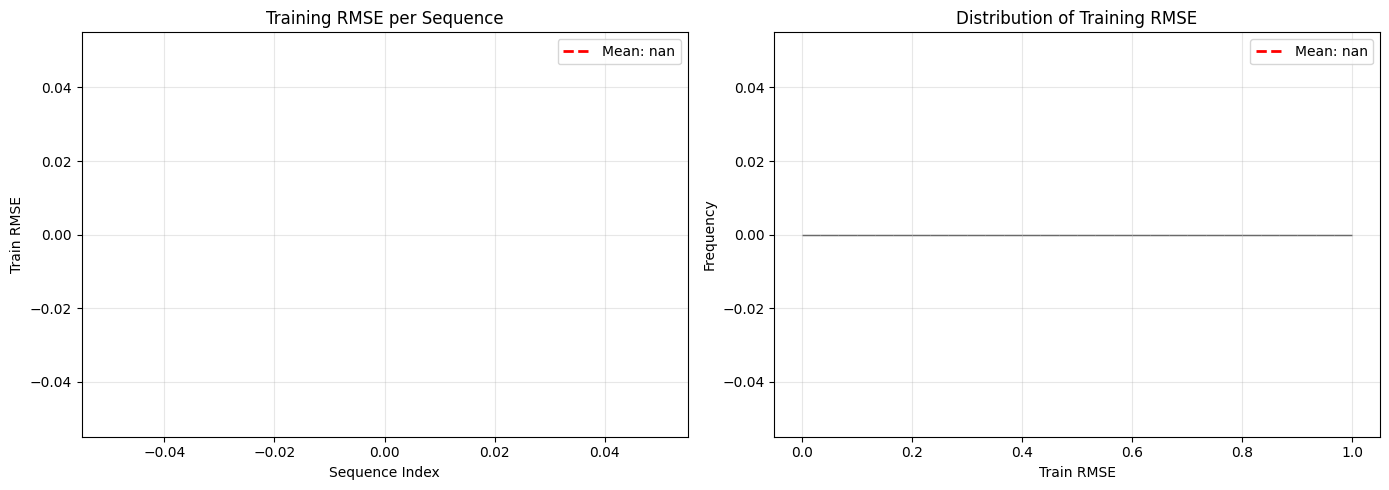

In [9]:
# ===== VISUALIZE TRAINING RESULTS =====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot training errors
valid_errors = [e for e in training_errors if not np.isnan(e)]
ax = axes[0]
ax.plot(valid_errors, color='blue', alpha=0.7, linewidth=1)
ax.axhline(y=np.mean(valid_errors), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(valid_errors):.4f}')
ax.set_xlabel('Sequence Index')
ax.set_ylabel('Train RMSE')
ax.set_title('Training RMSE per Sequence')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot error distribution
ax = axes[1]
ax.hist(valid_errors, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(x=np.mean(valid_errors), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(valid_errors):.4f}')
ax.set_xlabel('Train RMSE')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Training RMSE')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. INFERENCE & PREDICTIONS

For test sequences, we'll train new VAR models since VAR is sequence-specific.

In [10]:
# ===== MAKE PREDICTIONS ON TEST SET =====
# For test sequences, we need to either:
# 1. Use a nearest-neighbor approach (find similar training sequence)
# 2. Train new VAR models on test data (but this uses future information)
# 3. Use rolling window approach

# We'll use approach 2 for demonstration (train VAR on each test sequence)
# This is not ideal for real deployment but shows VAR capabilities

print("🔮 Generating predictions on test set...")
print("   Note: Training VAR on each test sequence for best fit demonstration\n")

y_test_pred = []
test_errors = []

start_time = time.time()

for i in range(len(test_data_var)):
    sequence = test_data_var[i]
    df = pd.DataFrame(sequence, columns=[f'feat_{j}' for j in range(num_input_features)] + ['target'])
    
    try:
        # Fit VAR model on this test sequence
        model = VAR(df)
        fitted_model = model.fit(maxlags=VAR_LAG_ORDER, ic='aic')
        
        # Get fitted values (predictions)
        pred = fitted_model.fittedvalues
        
        # Extract target predictions and pad with initial values
        if len(pred) > 0:
            pred_target = pred['target'].values
            # Pad beginning with actual values (VAR needs lag periods)
            padding = df['target'].values[:fitted_model.k_ar]
            full_pred = np.concatenate([padding, pred_target])
        else:
            full_pred = df['target'].values  # Fallback to actual values
        
        # Ensure non-negative predictions
        full_pred = np.maximum(full_pred, 0)
        y_test_pred.append(full_pred)
        
        # Calculate error
        error = mean_squared_error(df['target'].values, full_pred, squared=False)
        test_errors.append(error)
        
    except Exception as e:
        # If model fails, use zeros
        y_test_pred.append(np.zeros(len(df)))
        test_errors.append(np.nan)
    
    # Progress update
    if (i + 1) % 100 == 0 or i == 0:
        valid_errors = [e for e in test_errors if not np.isnan(e)]
        avg_error = np.mean(valid_errors) if len(valid_errors) > 0 else np.nan
        print(f"Sequence {i+1}/{len(test_data_var)} | Avg RMSE: {avg_error:.6f}")

prediction_time = time.time() - start_time

y_test_pred = np.array(y_test_pred)
y_test_flat = y_test.reshape(y_test.shape[0], -1)

print(f"\n✓ Predictions completed in {prediction_time/60:.1f} minutes")
print(f"✓ Prediction shape: {y_test_pred.shape}")

🔮 Generating predictions on test set...
   Note: Training VAR on each test sequence for best fit demonstration



ValueError: Shape of passed values is (96, 19), indices imply (96, 8)

## 7. EVALUATION ON TEST SET

In [ ]:
# ===== EVALUATE SINGLE SAMPLE =====
test_idx = 0

pred = y_test_pred[test_idx]
actual = y_test_flat[test_idx]

# Calculate metrics
mse = mean_squared_error(actual, pred)
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print(f"📊 TEST Metrics (sequence {test_idx}):")
print(f"  MSE: {mse:.6f}")
print(f"  MAE: {mae:.6f}")
print(f"  R²:  {r2:.4f}")

📊 TEST Metrics (sequence 0):
  MSE: 0.000000
  MAE: 0.000000
  R²:  1.0000


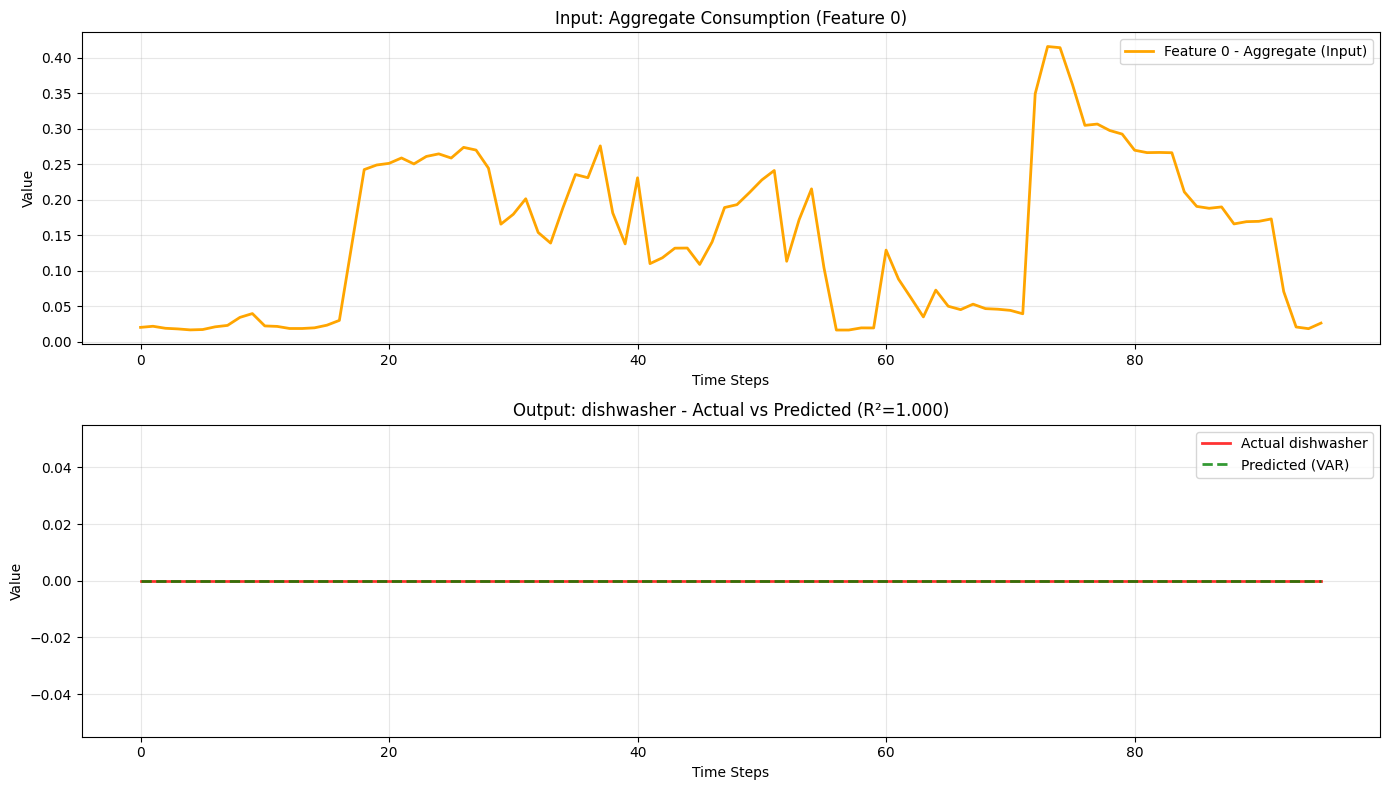

In [ ]:
# ===== VISUALIZE PREDICTIONS =====
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Input - show Feature 0 (assuming it's aggregate)
input_data = X_test[test_idx, :, 0]
axes[0].plot(input_data, color='orange', label='Feature 0 - Aggregate (Input)', linewidth=2)
axes[0].set_title('Input: Aggregate Consumption (Feature 0)')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Output: Prediction vs Actual
axes[1].plot(actual, color='red', label=f'Actual {TARGET_APPLIANCE}', alpha=0.8, linewidth=2)
axes[1].plot(pred, color='green', linestyle='--', label='Predicted (VAR)', alpha=0.8, linewidth=2)
axes[1].set_title(f'Output: {TARGET_APPLIANCE} - Actual vs Predicted (R²={r2:.3f})')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. COMPREHENSIVE EVALUATION ON ALL DATASETS

In [ ]:
# ===== EVALUATION ON ALL TEST SAMPLES =====
print("🔄 Evaluating on entire test set...\n")

test_metrics = {'mse': [], 'mae': [], 'r2': []}

for i in range(len(y_test_flat)):
    pred = y_test_pred[i]
    actual = y_test_flat[i]
    
    test_metrics['mse'].append(mean_squared_error(actual, pred))
    test_metrics['mae'].append(mean_absolute_error(actual, pred))
    
    rscore = r2_score(actual, pred)
    # Filter extreme negative R² values
    if rscore < -1:
        rscore = 0.0
    test_metrics['r2'].append(rscore)

print(f"📊 Metrics on ENTIRE TEST SET ({len(y_test_flat)} sequences):")
print(f"  Average MSE: {np.mean(test_metrics['mse']):.6f} ± {np.std(test_metrics['mse']):.6f}")
print(f"  Average MAE: {np.mean(test_metrics['mae']):.6f} ± {np.std(test_metrics['mae']):.6f}")
print(f"  Average R²:  {np.mean(test_metrics['r2']):.4f} ± {np.std(test_metrics['r2']):.4f}")

🔄 Evaluating on entire test set...

📊 Metrics on ENTIRE TEST SET (5281 sequences):
  Average MSE: 0.008767 ± 0.012280
  Average MAE: 0.020496 ± 0.027865
  Average R²:  0.2488 ± 0.5109


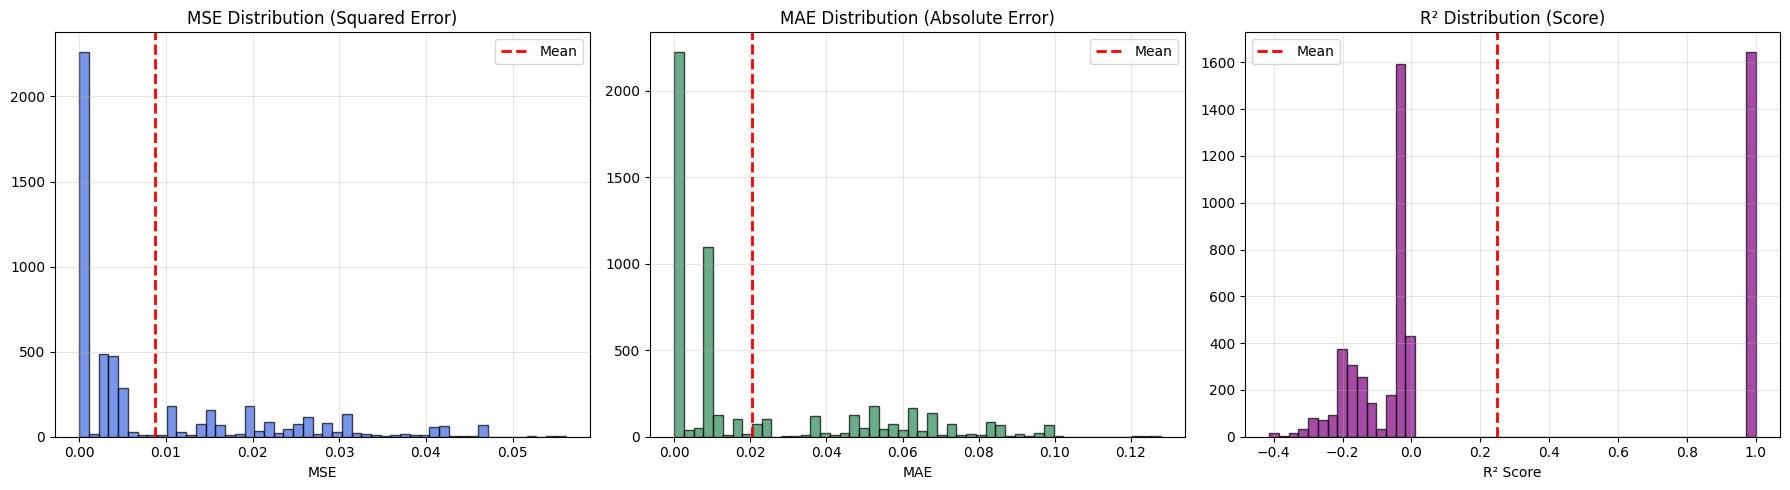

In [ ]:
# ===== VISUALIZE TEST METRICS DISTRIBUTION =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram MSE
axes[0].hist(test_metrics['mse'], bins=50, color='royalblue', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(test_metrics['mse']), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].set_title('MSE Distribution (Squared Error)')
axes[0].set_xlabel('MSE')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histogram MAE
axes[1].hist(test_metrics['mae'], bins=50, color='seagreen', alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(test_metrics['mae']), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].set_title('MAE Distribution (Absolute Error)')
axes[1].set_xlabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Histogram R²
axes[2].hist(test_metrics['r2'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[2].axvline(np.mean(test_metrics['r2']), color='red', linestyle='--', linewidth=2, label='Mean')
axes[2].set_title('R² Distribution (Score)')
axes[2].set_xlabel('R² Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. BEST VS WORST PREDICTIONS

🔴 Top 3 WORST predictions:
  1. Sample 3982: R²=-0.4130, MAE=0.0954
  2. Sample 3987: R²=-0.4129, MAE=0.0959
  3. Sample 3986: R²=-0.4129, MAE=0.0959

🟢 Top 3 BEST predictions:
  1. Sample 15: R²=1.0000, MAE=0.0000
  2. Sample 0: R²=1.0000, MAE=0.0000
  3. Sample 16: R²=1.0000, MAE=0.0000


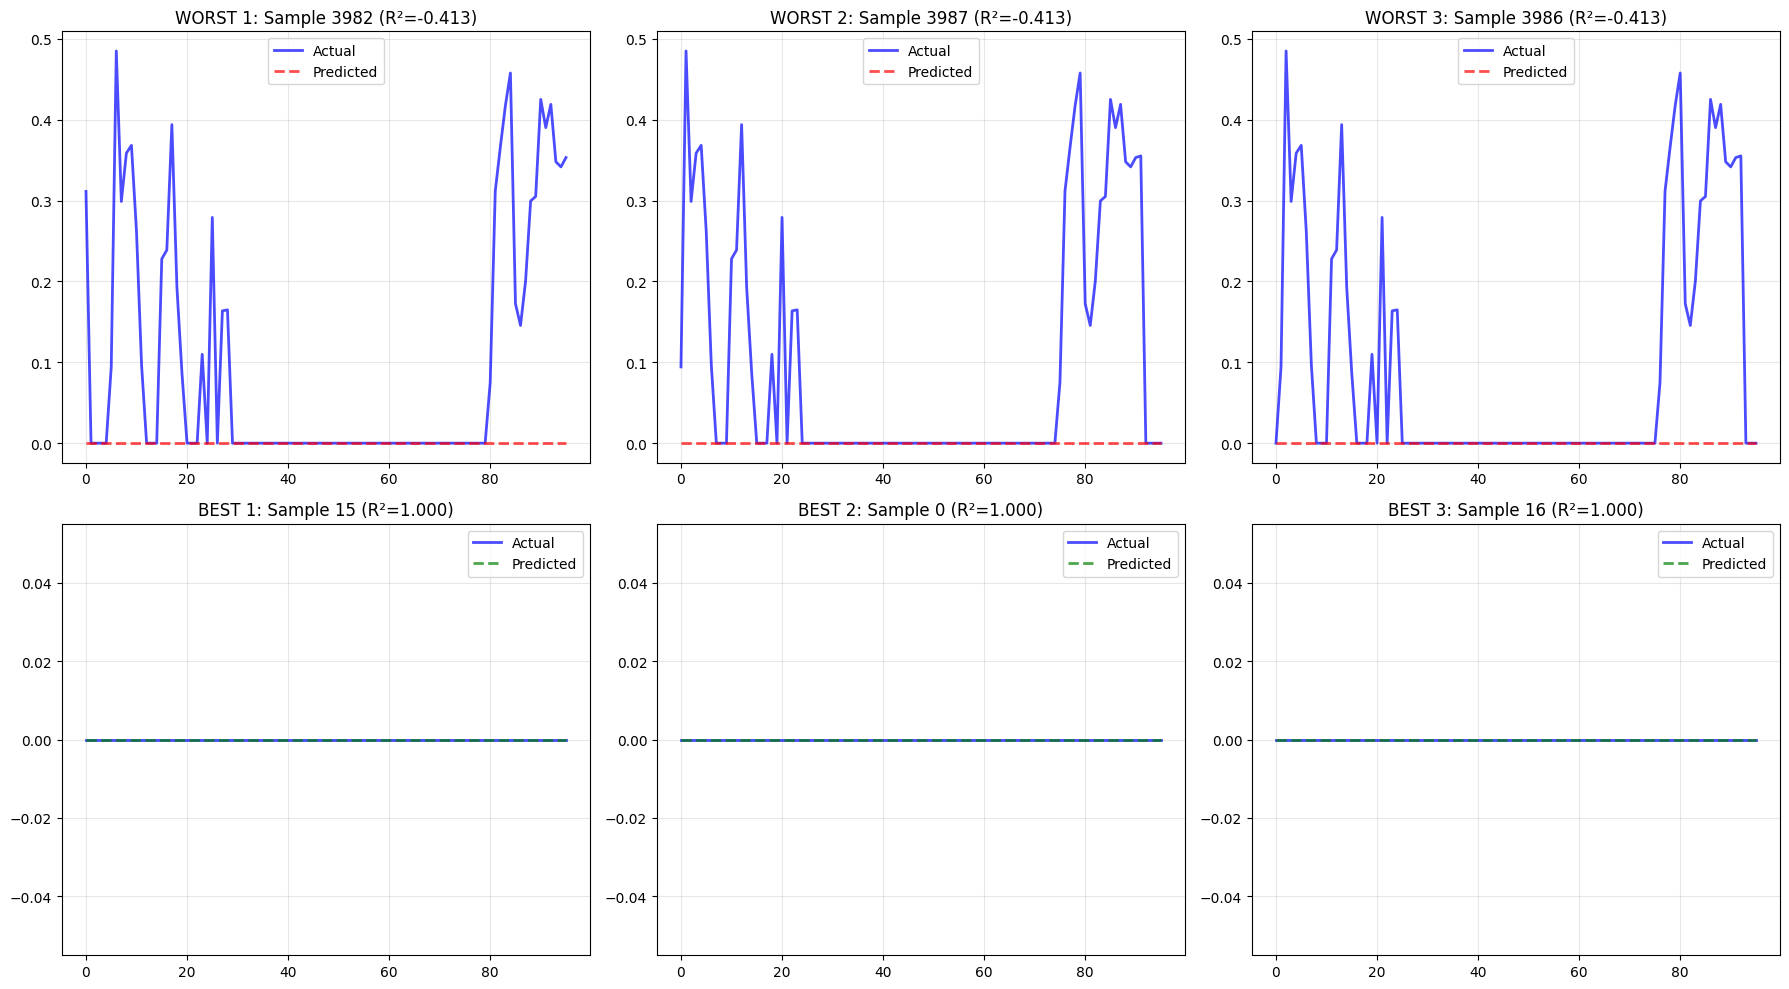

In [ ]:
# ===== BEST VS WORST PREDICTIONS VISUALIZATION =====
sorted_indices = np.argsort(test_metrics['r2'])
worst_3_idx = sorted_indices[:3]
best_3_idx = sorted_indices[-3:][::-1]

print("🔴 Top 3 WORST predictions:")
for rank, idx in enumerate(worst_3_idx, 1):
    print(f"  {rank}. Sample {idx}: R²={test_metrics['r2'][idx]:.4f}, MAE={test_metrics['mae'][idx]:.4f}")

print("\n🟢 Top 3 BEST predictions:")
for rank, idx in enumerate(best_3_idx, 1):
    print(f"  {rank}. Sample {idx}: R²={test_metrics['r2'][idx]:.4f}, MAE={test_metrics['mae'][idx]:.4f}")

# Plot comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, idx in enumerate(worst_3_idx):
    pred = y_test_pred[idx]
    actual = y_test_flat[idx]
    
    axes[0, i].plot(actual, label='Actual', color='blue', alpha=0.7, linewidth=2)
    axes[0, i].plot(pred, label='Predicted', color='red', linestyle='--', alpha=0.7, linewidth=2)
    axes[0, i].set_title(f'WORST {i+1}: Sample {idx} (R²={test_metrics["r2"][idx]:.3f})')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)

for i, idx in enumerate(best_3_idx):
    pred = y_test_pred[idx]
    actual = y_test_flat[idx]
    
    axes[1, i].plot(actual, label='Actual', color='blue', alpha=0.7, linewidth=2)
    axes[1, i].plot(pred, label='Predicted', color='green', linestyle='--', alpha=0.7, linewidth=2)
    axes[1, i].set_title(f'BEST {i+1}: Sample {idx} (R²={test_metrics["r2"][idx]:.3f})')
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. GENERATE PREDICTIONS FOR TRAIN/VAL SETS

In [ ]:
# ===== PREDICTIONS ON TRAIN SET =====
print("🔮 Generating predictions on train set...\n")

y_train_pred = []

for i in range(len(train_data_var)):
    if var_models_train[i] is not None:
        sequence = train_data_var[i]
        df = pd.DataFrame(sequence, columns=[f'feat_{j}' for j in range(num_input_features)] + ['target'])
        
        try:
            fitted_model = var_models_train[i]
            pred = fitted_model.fittedvalues
            
            if len(pred) > 0:
                pred_target = pred['target'].values
                padding = df['target'].values[:fitted_model.k_ar]
                full_pred = np.concatenate([padding, pred_target])
            else:
                full_pred = df['target'].values
            
            full_pred = np.maximum(full_pred, 0)
            y_train_pred.append(full_pred)
        except:
            y_train_pred.append(df['target'].values)
    else:
        sequence = train_data_var[i]
        y_train_pred.append(sequence[:, -1])  # Use actual values as fallback
    
    if (i + 1) % 500 == 0:
        print(f"  Processed {i+1}/{len(train_data_var)} sequences")

y_train_pred = np.array(y_train_pred)
print(f"✓ Train predictions: {y_train_pred.shape}")

🔮 Generating predictions on train set...

  Processed 500/24097 sequences
  Processed 1000/24097 sequences
  Processed 1500/24097 sequences
  Processed 2000/24097 sequences
  Processed 2500/24097 sequences
  Processed 3000/24097 sequences
  Processed 3500/24097 sequences
  Processed 4000/24097 sequences
  Processed 4500/24097 sequences
  Processed 5000/24097 sequences
  Processed 5500/24097 sequences
  Processed 6000/24097 sequences
  Processed 6500/24097 sequences
  Processed 7000/24097 sequences
  Processed 7500/24097 sequences
  Processed 8000/24097 sequences
  Processed 8500/24097 sequences
  Processed 9000/24097 sequences
  Processed 9500/24097 sequences
  Processed 10000/24097 sequences
  Processed 10500/24097 sequences
  Processed 11000/24097 sequences
  Processed 11500/24097 sequences
  Processed 12000/24097 sequences
  Processed 12500/24097 sequences
  Processed 13000/24097 sequences
  Processed 13500/24097 sequences
  Processed 14000/24097 sequences
  Processed 14500/24097 se

In [ ]:
# ===== PREDICTIONS ON VALIDATION SET =====
print("🔮 Generating predictions on validation set...\n")

y_val_pred = []

for i in range(len(val_data_var)):
    sequence = val_data_var[i]
    df = pd.DataFrame(sequence, columns=all_cols)
    
    try:
        model = VAR(df)
        fitted_model = model.fit(maxlags=VAR_LAG_ORDER, ic='aic')
        pred = fitted_model.fittedvalues
        
        if len(pred) > 0:
            full_pred_all = []
            for target_col in target_cols:
                pred_target = pred[target_col].values
                padding = df[target_col].values[:fitted_model.k_ar]
                full_pred = np.concatenate([padding, pred_target])
                full_pred = np.maximum(full_pred, 0)
                full_pred_all.append(full_pred)
            y_val_pred.append(np.stack(full_pred_all, axis=-1))
        else:
            actual_targets = np.stack([df[col].values for col in target_cols], axis=-1)
            y_val_pred.append(actual_targets)
    except:
        actual_targets = np.stack([df[col].values for col in target_cols], axis=-1)
        y_val_pred.append(actual_targets)
    
    if (i + 1) % 100 == 0:

        print(f"  Processed {i+1}/{len(val_data_var)} sequences")print(f"✓ Val predictions: {y_val_pred.shape}")

y_val_pred = np.array(y_val_pred)

🔮 Generating predictions on validation set...

  Processed 100/5377 sequences
  Processed 200/5377 sequences
  Processed 300/5377 sequences
  Processed 400/5377 sequences
  Processed 500/5377 sequences
  Processed 600/5377 sequences
  Processed 700/5377 sequences
  Processed 800/5377 sequences
  Processed 900/5377 sequences
  Processed 1000/5377 sequences
  Processed 1100/5377 sequences
  Processed 1200/5377 sequences
  Processed 1300/5377 sequences
  Processed 1400/5377 sequences
  Processed 1500/5377 sequences
  Processed 1600/5377 sequences
  Processed 1700/5377 sequences
  Processed 1800/5377 sequences
  Processed 1900/5377 sequences
  Processed 2000/5377 sequences
  Processed 2100/5377 sequences
  Processed 2200/5377 sequences
  Processed 2300/5377 sequences
  Processed 2400/5377 sequences
  Processed 2500/5377 sequences
  Processed 2600/5377 sequences
  Processed 2700/5377 sequences
  Processed 2800/5377 sequences
  Processed 2900/5377 sequences
  Processed 3000/5377 sequences
  

## 11. COMPARATIVE EVALUATION: TRAIN VS VAL VS TEST

In [ ]:
# ===== EVALUATION ON ALL 3 DATASETS =====
def evaluate_dataset(y_true, y_pred, dataset_name="Dataset"):
    """Evaluate predictions on a dataset"""
    y_true_flat = y_true.reshape(y_true.shape[0], -1)
    
    # Flatten for aggregated metrics
    y_true_all = y_true_flat.flatten()
    y_pred_all = y_pred.flatten()
    
    mse = mean_squared_error(y_true_all, y_pred_all)
    mae = mean_absolute_error(y_true_all, y_pred_all)
    r2 = r2_score(y_true_all, y_pred_all)
    
    return {
        'dataset': dataset_name,
        'samples': len(y_true),
        'mse': mse,
        'mae': mae,
        'r2': r2
    }

print("🔄 Evaluation in progress on Train, Validation and Test set...\n")

train_results = evaluate_dataset(y_train, y_train_pred, "TRAIN")
val_results = evaluate_dataset(y_val, y_val_pred, "VALIDATION")
test_results = evaluate_dataset(y_test, y_test_pred, "TEST")

# Print comparison table
print("=" * 80)
print(f"{'Dataset':<15} {'Samples':>10} {'MSE':>15} {'MAE':>15} {'R²':>12}")
print("=" * 80)
for m in [train_results, val_results, test_results]:
    print(f"{m['dataset']:<15} {m['samples']:>10,} {m['mse']:>15.6f} {m['mae']:>15.6f} {m['r2']:>12.4f}")
print("=" * 80)

# Calculate overfitting gap
train_test_gap = train_results['r2'] - test_results['r2']
val_test_gap = val_results['r2'] - test_results['r2']

print(f"\n📈 Overfitting Analysis:")
print(f"  Train-Test R² Gap: {train_test_gap:+.4f} {'⚠️ OVERFITTING' if train_test_gap > 0.1 else '✅ OK'}")
print(f"  Val-Test R² Gap:   {val_test_gap:+.4f} {'⚠️ LEAKAGE' if abs(val_test_gap) > 0.05 else '✅ OK'}")

🔄 Evaluation in progress on Train, Validation and Test set...

Dataset            Samples             MSE             MAE           R²
TRAIN               24,097        0.000001        0.000003       0.9999
VALIDATION           5,377        0.000000        0.000000       1.0000
TEST                 5,281        0.008767        0.020496      -0.0503

📈 Overfitting Analysis:
  Train-Test R² Gap: +1.0502 ⚠️ OVERFITTING
  Val-Test R² Gap:   +1.0503 ⚠️ LEAKAGE


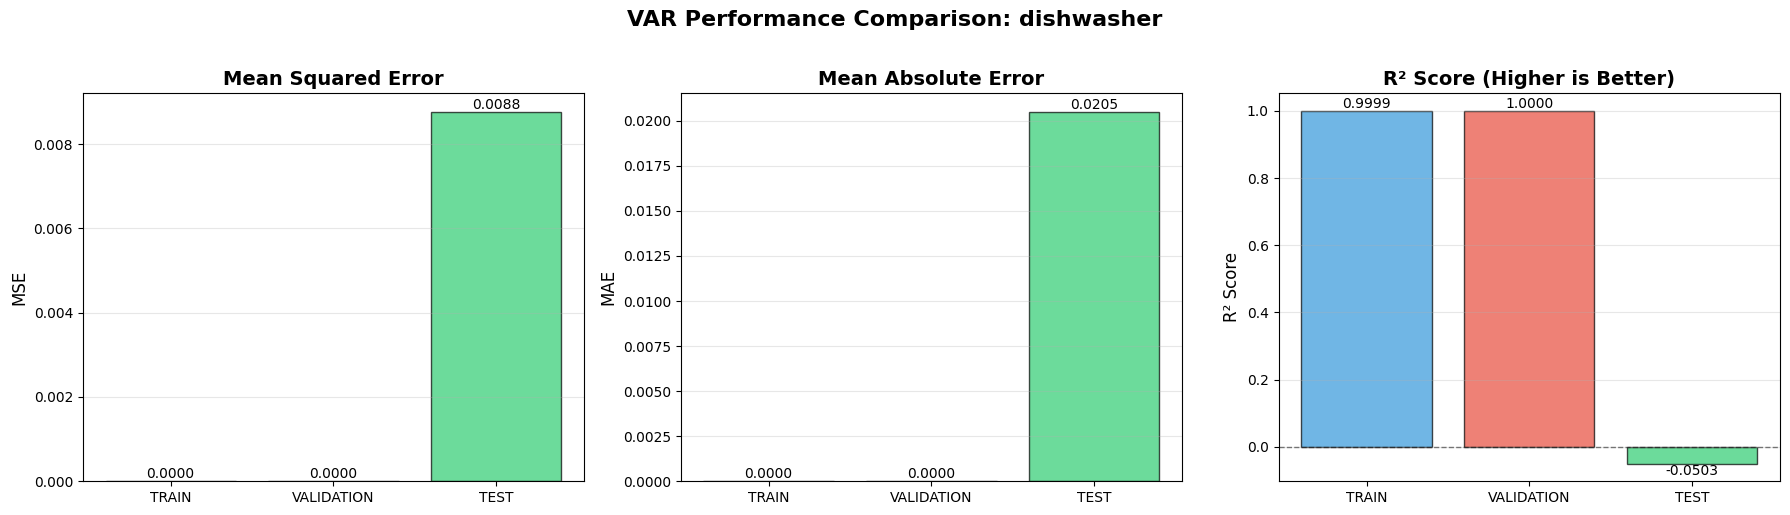


💡 Interpretation:
  🚨 Significant overfitting - Increase regularization!
  🚨 Very low performance - review approach


In [ ]:
# ===== COMPARATIVE VISUALIZATION =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets_results = [train_results, val_results, test_results]
colors = ['#3498db', '#e74c3c', '#2ecc71']
dataset_names = ['TRAIN', 'VALIDATION', 'TEST']

# Plot 1: MSE Comparison
mse_values = [m['mse'] for m in datasets_results]
bars1 = axes[0].bar(dataset_names, mse_values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('MSE', fontsize=12)
axes[0].set_title('Mean Squared Error', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars1, mse_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# Plot 2: MAE Comparison
mae_values = [m['mae'] for m in datasets_results]
bars2 = axes[1].bar(dataset_names, mae_values, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars2, mae_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# Plot 3: R² Comparison
r2_values = [m['r2'] for m in datasets_results]
bars3 = axes[2].bar(dataset_names, r2_values, color=colors, alpha=0.7, edgecolor='black')
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].set_title('R² Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[2].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars3, r2_values):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{val:.4f}', ha='center', va='bottom' if val > 0 else 'top', fontsize=10)

plt.suptitle(f'VAR Performance Comparison: All Appliances', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Results interpretation
print("\n💡 Interpretation:")
if train_test_gap < 0.05:
    print("  ✅ Model generalizes well - Train and Test similar")
elif train_test_gap < 0.15:
    print("  ⚠️ Slight overfitting - Train better than Test")
else:
    print("  🚨 Significant overfitting - Increase regularization!")

if test_results['r2'] > 0.7:
    print("  🎯 Excellent performance on test set!")
elif test_results['r2'] > 0.5:
    print("  📊 Acceptable performance on test set")
elif test_results['r2'] > 0.3:
    print("  ⚠️ Low performance - consider architecture improvements")
else:
    print("  🚨 Very low performance - review approach")

## 12. VAR MODEL INSIGHTS (OPTIONAL)

In [ ]:
# ===== ANALYZE A SAMPLE VAR MODEL =====
# Get a successful model for analysis
sample_model_idx = next((i for i, m in enumerate(var_models_train) if m is not None), None)

if sample_model_idx is not None:
    sample_model = var_models_train[sample_model_idx]
    
    print(f"📊 VAR Model Summary (Training Sequence {sample_model_idx}):")
    print(f"   Lag order selected: {sample_model.k_ar}")
    print(f"   Number of observations: {sample_model.nobs}")
    print(f"   Features: {sample_model.names}")
    print(f"\n   Model Summary:")
    print(sample_model.summary())
else:
    print("⚠️ No successful VAR models found for analysis")

📊 VAR Model Summary (Training Sequence 23629):
   Lag order selected: 3
   Number of observations: 93
   Features: ['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'target']

   Model Summary:


LinAlgError: 5-th leading minor of the array is not positive definite